### Importing packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

alt.data_transformers.disable_max_rows()
##Altair color schemes: https://vega.github.io/vega/docs/schemes/

DataTransformerRegistry.enable('default')

# Dispatch Model Curves

## Edge case with constrained charge/discharge cycle

In [4]:
price = pd.read_csv('../data/raw/PriceCurve_SE4_2021.csv' , sep = ';')
co2_pro = pd.read_csv('../data/raw/production_emissions.csv')
co2_con = pd.read_csv('../data/raw/consumption_emissions.csv')
pv = pd.read_csv('../data/raw/oskarshamnpvprod.csv')
#load = pd.read_csv('../data/raw/LoadCurve.csv', sep = ';')
load = pd.read_csv('../data/raw/LoadCurveo.csv', sep = ',')


data = load
data['Price'] = price['Grid_Price']
#data['Price'] = price
data['CO_2_eq'] = co2_pro['carbon_intensity_production_avg']
data['solar_PV'] = pv

#Converting from MW to kW
data['Load']= (data['Load'] * 1000)
#solar data is already in kW, but needs to be multiplied by the scaling factor
data['solar_PV']= (data['solar_PV'])
data['Price']= (data['Price'] / 1000)
data['CO_2_eq']= (data['CO_2_eq'] / 1000)

data['Hour']= (data['Hour']).astype('int')

#data.head(48)
#data.head(10)

duplicated_rows = pd.concat([data.iloc[[-1]]] * 49, ignore_index=True)
#duplicated_rows

data = pd.concat([data, duplicated_rows], ignore_index=True)

#data.head(48)
#data.head(10)
#data

In [ ]:
profile= pd.read_csv(
    '../data/interim/CaseB/price_2_2_2.csv',
    sep= ',',
    index_col=False,
)
#profile['SoC']= ((profile['SoC']/20000)*1000).astype('float')
profile['SoC']= ((profile['SoC']/9000)*100).astype('float')

# p_solar=    10
# p_bess=     1
# t_bess=     2
# e_bess=     p_bess * t_bess
p_solar=    9
p_bess=     3
t_bess=     2
e_bess=     p_bess * t_bess

efficiency_charge=      0.90
efficiency_discharge=   0.90
efficiency_inverter=    0.97

week= 24

#profile.info()
#profile[47:96]

In [7]:
profile['P_PV_to_Grid']=    profile['P_PV_to_Grid']     * efficiency_inverter
profile['P_PV_to_Load']=    profile['P_PV_to_Load']     * efficiency_inverter
profile['P_PV_to_BESS']=    profile['P_PV_to_BESS']     * efficiency_charge     * efficiency_inverter
profile['P_BESS_to_Grid']=  profile['P_BESS_to_Grid']   * efficiency_discharge  * efficiency_inverter
profile['P_BESS_to_Load']=  profile['P_BESS_to_Load']   * efficiency_discharge  * efficiency_inverter
profile['P_Grid_to_BESS']=  profile['P_Grid_to_BESS']   * efficiency_charge     * efficiency_inverter
#profile

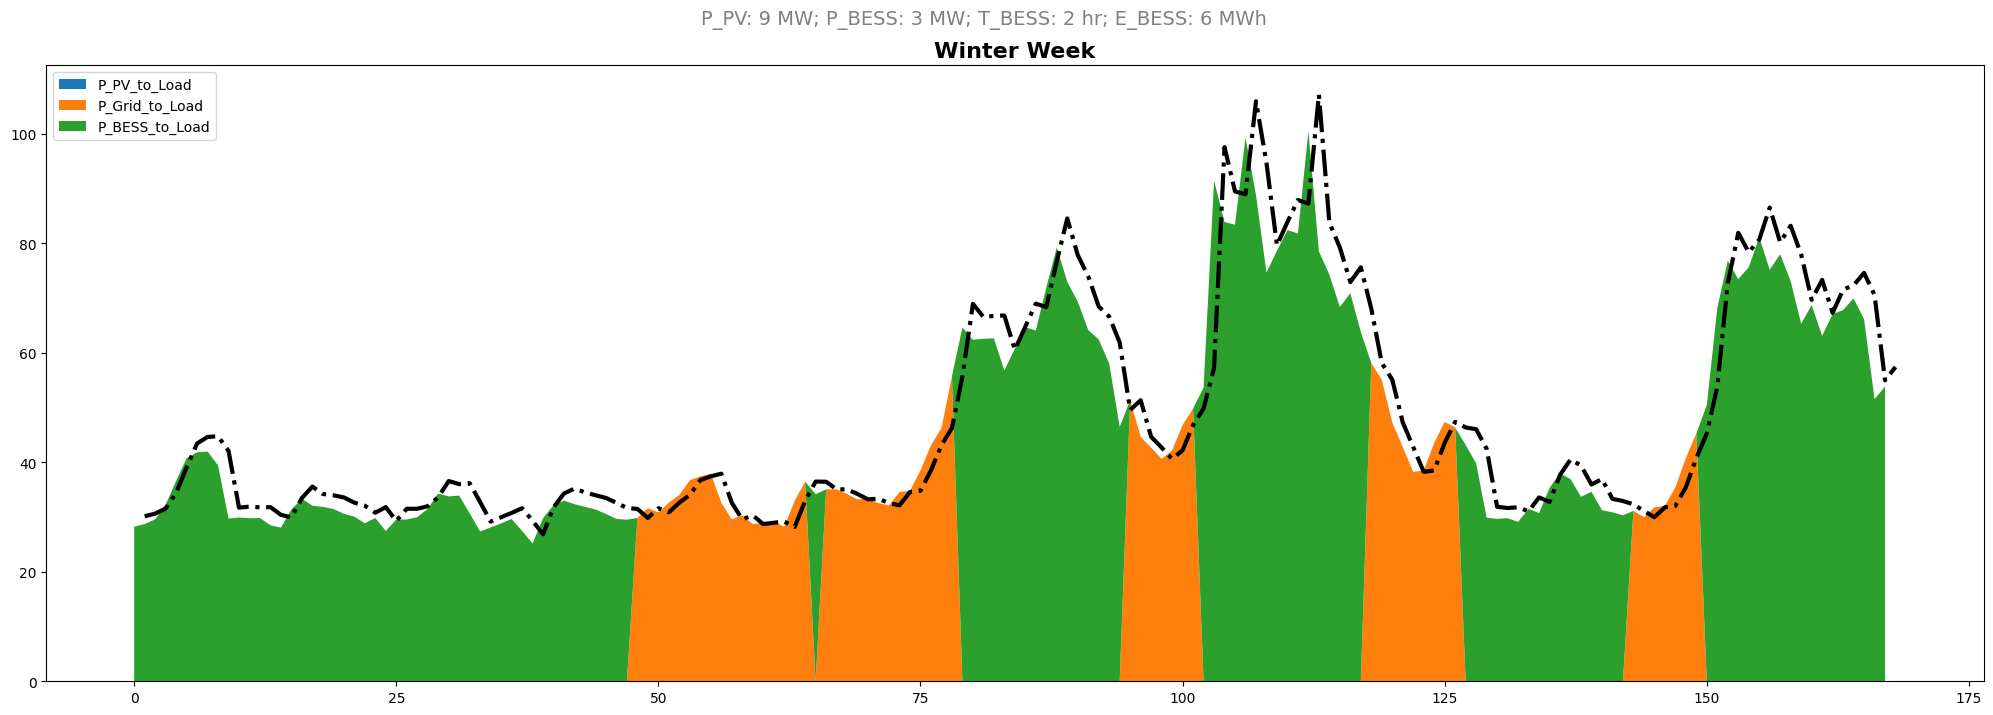

In [8]:
fig= plt.figure(
    figsize= (25,8),
)
title= plt.title('Winter Week', fontsize= 16, fontweight= 'bold')
#ax1.set_title('Winter Week', fontsize=16, fontweight='bold')
fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')

plt.stackplot(
    profile[:168].Hour,
    profile[:168].P_PV_to_Load,
    profile[:168].P_Grid_to_Load,
    profile[:168].P_BESS_to_Load,
    labels=[
        'P_PV_to_Load',
        'P_Grid_to_Load',
        'P_BESS_to_Load',
    ],
)
#plt.plot(profile[:168].Hour, profile[:168].sum_power_flows, linestyle= 'dashdot', linewidth= 2)
plt.plot(data[:168].Hour, data[:168].Load, linestyle= 'dashdot', linewidth= 3, color= 'black')
plt.legend(loc='upper left')


In [9]:
dispatch_with_bars= pd.melt(
    profile[:168],
    id_vars= ['Hour'],
    value_vars= [
        'P_PV_to_Load',
        'P_BESS_to_Load',
        'P_Grid_to_Load',
    ],
    var_name= 'flow',
    value_name= 'value'
)
color_mapping= {
    'P_PV_to_Load': 'orange',
    'P_BESS_to_Load': 'blue',
    'P_Grid_to_Load': 'red',
}



alt.Chart(
    dispatch_with_bars,
    title= alt.Title(
        'Winter Week',
        subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    )
).mark_bar().encode(
    x= alt.X('Hour:Q'),
    y= alt.Y('value:Q'),
    color= alt.Color(
        'flow:N',
        scale= alt.Scale(
            domain= list(color_mapping.keys()),
            range= list(color_mapping.values())
        )
    )
).properties(
    height= 300,
    width= 1200
)

/home/leo/anaconda3/envs/BESS/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

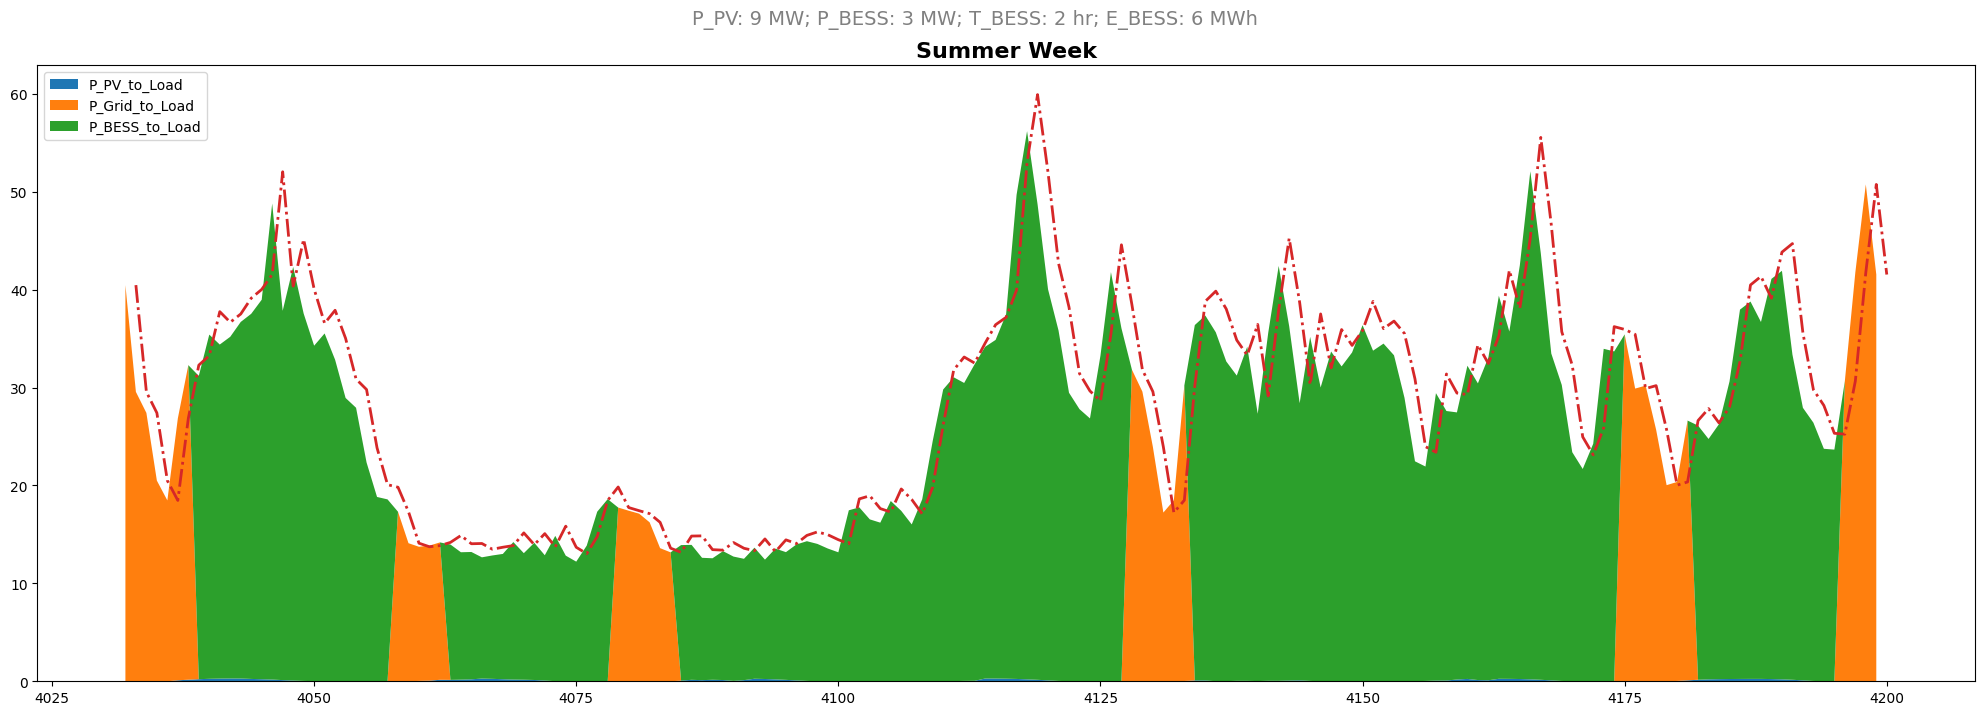

In [10]:
fig= plt.figure(
    figsize= (25,8)
)
title= plt.title('Summer Week', fontsize= 16, fontweight= 'bold')
#ax1.set_title('Winter Week', fontsize=16, fontweight='bold')
fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')

plt.stackplot(
    profile[(week * 168):(week + 1) * 168].Hour,
    profile[(week * 168):(week + 1) * 168].P_PV_to_Load,
    profile[(week * 168):(week + 1) * 168].P_Grid_to_Load,
    profile[(week * 168):(week + 1) * 168].P_BESS_to_Load,
    labels=[
        'P_PV_to_Load',
        'P_Grid_to_Load',
        'P_BESS_to_Load',
    ],
)
#plt.plot(profile[(week * 168):(week + 1) * 168].Hour, profile[(week * 168):(week + 1) * 168].sum_power_flows, linestyle= 'dashdot', linewidth= 2)
plt.plot(data[(week * 168):(week + 1) * 168].Hour, data[(week * 168):(week + 1) * 168].Load, linestyle= 'dashdot', linewidth= 2)
plt.legend(loc='upper left')


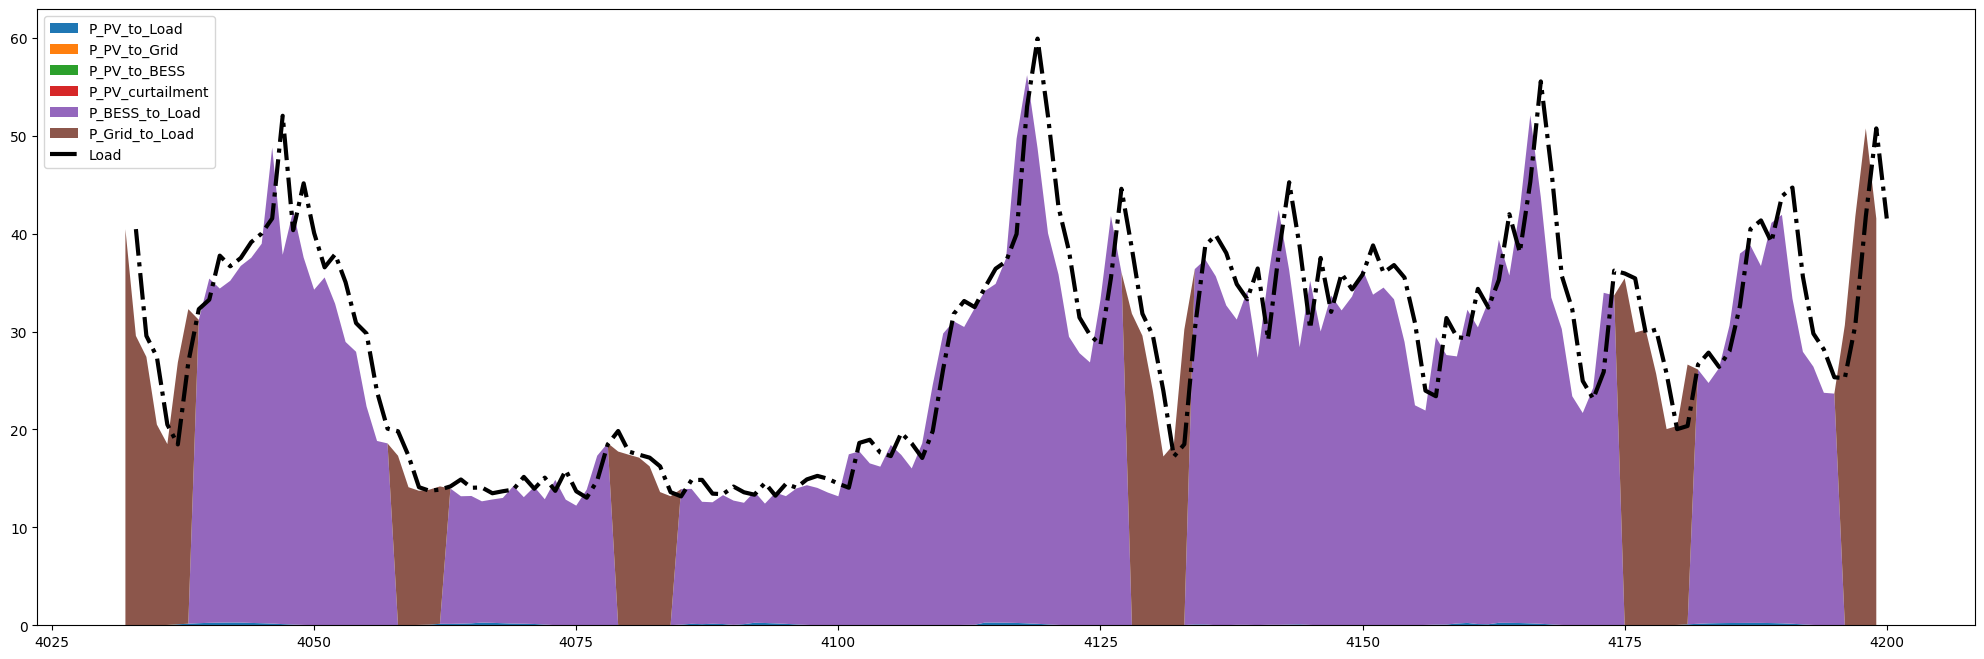

In [11]:
fig= plt.figure(
    figsize= (25,8)
)
#title= plt.title('Summer Week', fontsize= 16, fontweight= 'bold')
#ax1.set_title('Winter Week', fontsize=16, fontweight='bold')
#fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')

plt.stackplot(
    profile[(week * 168):(week + 1) * 168].Hour,
    profile[(week * 168):(week + 1) * 168].P_PV_to_Load,
    profile[(week * 168):(week + 1) * 168].P_PV_to_Grid,
    profile[(week * 168):(week + 1) * 168].P_PV_to_BESS,
    profile[(week * 168):(week + 1) * 168].P_PV_curtailment,
    profile[(week * 168):(week + 1) * 168].P_BESS_to_Load,
    profile[(week * 168):(week + 1) * 168].P_Grid_to_Load,
    labels=[
        'P_PV_to_Load',
        'P_PV_to_Grid',
        'P_PV_to_BESS',
        'P_PV_curtailment',
        'P_BESS_to_Load',
        'P_Grid_to_Load'        
    ],
)
plt.plot(
    data[(week * 168):(week + 1) * 168].Hour,
    data[(week * 168):(week + 1) * 168].Load,
    label= 'Load',
    linestyle= 'dashdot',
    linewidth= 3,
    color= 'black'
)

plt.legend(loc='upper left')


In [12]:
profile= profile[:6200]
profile.info()
profile

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6200 entries, 0 to 6199
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Hour              6200 non-null   int64  
 1   P_PV_to_Load      6200 non-null   float64
 2   P_PV_to_BESS      6200 non-null   float64
 3   P_PV_curtailment  6200 non-null   float64
 4   P_PV_to_Grid      6200 non-null   float64
 5   P_BESS_to_Load    6200 non-null   float64
 6   P_BESS_to_Grid    6200 non-null   float64
 7   P_Grid_to_Load    6200 non-null   float64
 8   P_Grid_to_BESS    6200 non-null   float64
 9   SoC               6200 non-null   float64
 10  sum_power_flows   6200 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 532.9 KB


,Hour,P_PV_to_Load,P_PV_to_BESS,P_PV_curtailment,P_PV_to_Grid,P_BESS_to_Load,P_BESS_to_Grid,P_Grid_to_Load,P_Grid_to_BESS,SoC,sum_power_flows
0,0,0.000000,0.000000,0.0,0.0,28.256561,0.0,-3.552714e-15,0.000000,66.280460,32.367195
1,1,0.000000,0.000000,0.0,0.0,28.718774,0.0,0.000000e+00,0.000000,65.887936,32.896648
2,2,0.000000,0.000000,0.0,0.0,29.581569,0.0,-3.552714e-15,0.000000,65.483620,33.884959
3,3,0.000000,0.000000,0.0,0.0,32.262399,0.0,0.000000e+00,0.000000,65.042662,36.955784
4,4,0.000000,0.000000,0.0,0.0,36.607193,0.0,0.000000e+00,0.000000,64.542320,41.932637
...,...,...,...,...,...,...,...,...,...,...,...
6195,6195,0.000000,0.000000,0.0,0.0,0.000000,0.0,2.509963e+01,0.000000,13.333333,25.099633
6196,6196,0.000000,0.000000,0.0,0.0,0.000000,0.0,3.099656e+01,0.000000,13.333333,30.996555
6197,6197,0.000000,0.022113,0.0,0.0,0.000000,0.0,4.775550e+01,1552.392225,32.115630,47.755500
6198,6198,0.000000,0.085219,0.0,0.0,0.000000,0.0,5.702472e+01,0.000000,32.116661,57.024720


In [13]:
columns_of_interest = ['Hour', 'P_PV_to_Load', 'P_PV_to_Grid', 'P_PV_to_BESS', 'P_PV_curtailment', 'P_BESS_to_Load', 'P_Grid_to_Load']
subset_data_2 = profile[columns_of_interest]

subset_data_2= subset_data_2[4029:4201]
subset_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 4029 to 4200
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Hour              172 non-null    int64  
 1   P_PV_to_Load      172 non-null    float64
 2   P_PV_to_Grid      172 non-null    float64
 3   P_PV_to_BESS      172 non-null    float64
 4   P_PV_curtailment  172 non-null    float64
 5   P_BESS_to_Load    172 non-null    float64
 6   P_Grid_to_Load    172 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 9.5 KB


In [14]:
alt.Chart(subset_data_2).mark_bar().encode(
    x= 'Hour:Q',
    y= 'P_PV_to_Load:Q'
)

alt.Chart(...)

In [15]:
base= alt.Chart(subset_data_2).mark_area().encode(
    x= alt.X(
        'Hour:Q'
    )
)

pv2load= base.encode(
    y= alt.Y(
        'P_PV_to_Load:Q',
        axis= alt.Axis(
            title= 'Power [MW]'
        )
    ),
    color= alt.Color(
        'P_PV_to_Load:O'
    )
)
pv2grid= base.encode(
    y= alt.Y(
        'P__to_Grid:Q',
        axis= alt.Axis(
            title= 'Power [MW]'
        )
    ),
    color= alt.Color(
        'P__to_Grid:O'
    )
)
pv2bess= base.encode(
    y= alt.Y(
        'P_PV_to_BESS:Q',
        axis= alt.Axis(
            title= 'Power [MW]'
        )
    ),
    color= alt.Color(
        'P_PV_to_BESS:O'
    )
)
pv2curtailment= base.encode(
    y= alt.Y(
        'P_PV_curtailment:Q',
        axis= alt.Axis(
            title= 'Power [MW]'
        )
    ),
    color= alt.Color(
        'P_PV_curtailment:O'
    )
)
bess2load= base.encode(
    y= alt.Y(
        'P_BESS_to_Load:Q',
        axis= alt.Axis(
            title= 'Power [MW]'
        )
    ),
    color= alt.Color(
        'P_BESS_to_Load:O'
    )
)
grid2load= base.encode(
    y= alt.Y(
        'P_Grid_to_Load:Q',
        axis= alt.Axis(
            title= 'Power [MW]'
        )
    ),
    color= alt.Color(
        'P_Grid_to_Load:O'
    )
)

In [16]:
alt.layer(
    pv2load,
    pv2grid,
    pv2bess,
    pv2curtailment,
    bess2load,
    grid2load
)

alt.LayerChart(...)

In [17]:
# Select only the columns of interest
# columns_of_interest = [
#     'Hour',
#     'P_PV_to_Load',
#     'P_PV_to_Grid',
#     'P_PV_to_BESS',
#     'P_PV_curtailment',
#     'P_BESS_to_Load',
#     'P_Grid_to_Load'
# ]
# subset_data_2 = profile[columns_of_interest]

# Melt the DataFrame to long format
melted_data = subset_data_2.melt(id_vars=['Hour'], var_name='source', value_name='value')

alt.Chart(melted_data[4030:4201]).mark_area().encode(
    x= alt.X('Hour'),
    y= alt.Y(
        'value:Q', stack= 'zero'
    ),
    color= alt.Color(
        'source:N'
    )
)

/home/leo/anaconda3/envs/BESS/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [18]:
# fig= plt.figure(
#     figsize= (25,8)
# )
# title= plt.title('Summer Week', fontsize= 16, fontweight= 'bold')
# #ax1.set_title('Winter Week', fontsize=16, fontweight='bold')
# fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')

# plt.stackplot(
#     profile[(week * 168):(week + 1) * 168].Hour,
#     profile[(week * 168):(week + 1) * 168].P_PV_to_Load,
#     profile[(week * 168):(week + 1) * 168].P_PV_to_Grid,
#     profile[(week * 168):(week + 1) * 168].P_PV_to_BESS,
#     profile[(week * 168):(week + 1) * 168].P_PV_curtailment,
#     labels=[
#         'P_PV_to_Load',
#         'P_PV_to_Grid',
#         'P_PV_to_BESS',
#         'P_PV_curtailment'
#     ],
# )
# #plt.plot(profile[(week * 168):(week + 1) * 168].Hour, profile[(week * 168):(week + 1) * 168].sum_power_flows, linestyle= 'dashdot', linewidth= 2)
# plt.plot(data[(week * 168):(week + 1) * 168].Hour, data[(week * 168):(week + 1) * 168].Load, linestyle= 'dashdot', linewidth= 2)
# plt.legend(loc='upper left')


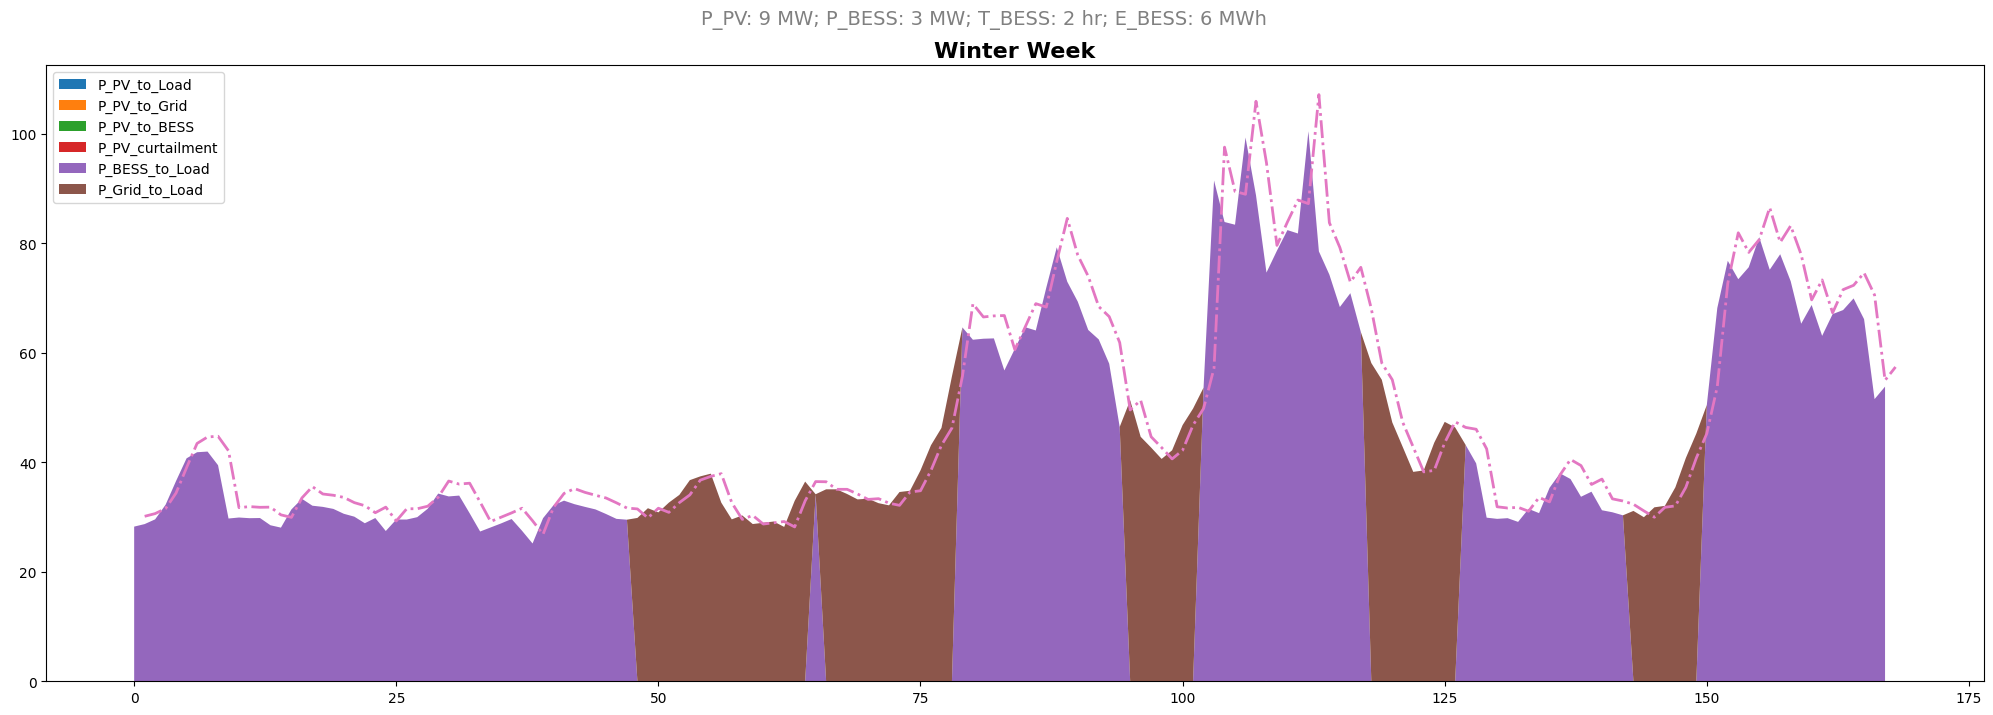

In [19]:
fig= plt.figure(
    figsize= (25,8)
)
title= plt.title('Winter Week', fontsize= 16, fontweight= 'bold')
#ax1.set_title('Winter Week', fontsize=16, fontweight='bold')
fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')
plt.stackplot(
    profile[:168].Hour,
    profile[:168].P_PV_to_Load,
    profile[:168].P_PV_to_Grid,
    profile[:168].P_PV_to_BESS,
    profile[:168].P_PV_curtailment,
    profile[:168].P_BESS_to_Load,
    profile[:168].P_Grid_to_Load,
    labels=[
        'P_PV_to_Load',
        'P_PV_to_Grid',
        'P_PV_to_BESS',
        'P_PV_curtailment',
        'P_BESS_to_Load',
        'P_Grid_to_Load'        
    ],
)
#plt.plot(profile[(week * 168):(week + 1) * 168].Hour, profile[(week * 168):(week + 1) * 168].sum_power_flows, linestyle= 'dashdot', linewidth= 2)
plt.plot(data[:168].Hour, data[:168].Load, linestyle= 'dashdot', linewidth= 2)
plt.legend(loc='upper left')


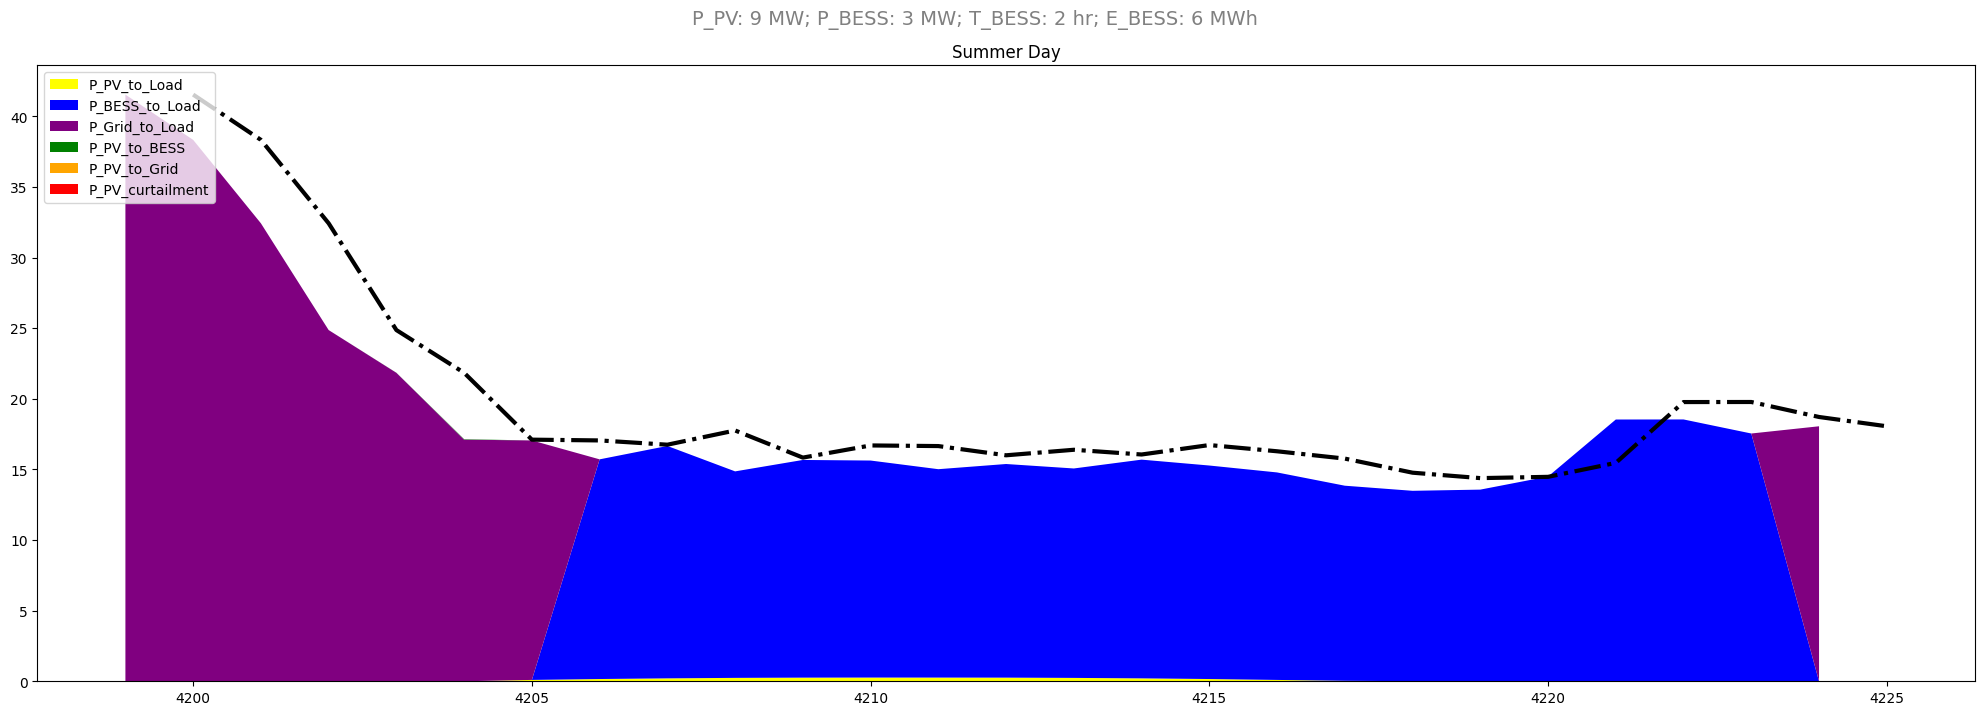

In [20]:
fig= plt.figure(
    figsize= (25,8)
)
title= plt.title('Summer Day')
fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')

custom_colors = [
    'yellow',
    'blue',
    'purple',
    'green',
    'orange',
    'red',
]
plt.stackplot(
    profile[4199:4225].Hour,
    profile[4199:4225].P_PV_to_Load,
    profile[4199:4225].P_BESS_to_Load,
    profile[4199:4225].P_Grid_to_Load,
    profile[4199:4225].P_PV_to_BESS,
    profile[4199:4225].P_PV_to_Grid,
    profile[4199:4225].P_PV_curtailment,
    labels=[
        'P_PV_to_Load',
        'P_BESS_to_Load',
        'P_Grid_to_Load',
        'P_PV_to_BESS',
        'P_PV_to_Grid',
        'P_PV_curtailment',
    ],
    colors= custom_colors
)
plt.plot(data[4199:4225].Hour, data[4199:4225].Load, linestyle= 'dashdot', linewidth= 3, color= 'black')
plt.legend(loc='upper left')


In [21]:
# # Assuming 'Hour', 'P_PV_to_BESS', 'P_BESS_to_Load', 'P_BESS_to_Grid', 'P_Grid_to_BESS', 'SoC' are columns in profile
# fig, ax1 = plt.subplots(figsize=(25,8))
# title= plt.title('P_PV: 10 MW; P_BESS: 5 MW; T_BESS: 4 hr')

# # Primary y-axis
# ax1.plot(profile[:168]['Hour'], profile[:168]['P_PV_to_BESS'], label='P_PV_to_BESS')
# ax1.plot(profile[:168]['Hour'], profile[:168]['P_BESS_to_Load'], label='P_BESS_to_Load')
# ax1.plot(profile[:168]['Hour'], profile[:168]['P_BESS_to_Grid'], label='P_BESS_to_Grid')
# ax1.plot(profile[:168]['Hour'], profile[:168]['P_Grid_to_BESS'], label='P_Grid_to_BESS')
# ax1.set_xlabel('Hour')
# ax1.set_ylabel('Flows in kW')

# # Create a twin Axes sharing the xaxis
# ax2 = ax1.twinx()
# ax2.plot(profile[:168]['Hour'], profile[:168]['SoC'], 'b', label='SoC', linestyle= 'dashdot')
# ax3 = ax1.twinx()
# ax3.plot(data[:168]['Hour'], data[:168]['Price'], 'red', label='Price', linestyle= ':')

# ax2.set_ylabel('SoC', color='b')
# ax2.tick_params(colors= 'b')
# ax3.set_ylabel('Price', color= 'r')
# ax3.tick_params(colors= 'r')

# # Combine legends for both axes
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# plt.show()


In [22]:
# # Assuming 'Hour', 'P_PV_to_BESS', 'P_BESS_to_Load', 'P_BESS_to_Grid', 'P_Grid_to_BESS', 'SoC' are columns in profile
# fig, ax1 = plt.subplots(figsize=(25,8))
# title= plt.title('P_PV: 10 MW; P_BESS: 5 MW; T_BESS: 4 hr')

# # Primary y-axis
# ax1.plot(profile[(week * 168):(week + 1) * 168]['Hour'], profile[(week * 168):(week + 1) * 168]['P_PV_to_BESS'], label='P_PV_to_BESS')
# ax1.plot(profile[(week * 168):(week + 1) * 168]['Hour'], profile[(week * 168):(week + 1) * 168]['P_BESS_to_Load'], label='P_BESS_to_Load')
# ax1.plot(profile[(week * 168):(week + 1) * 168]['Hour'], profile[(week * 168):(week + 1) * 168]['P_BESS_to_Grid'], label='P_BESS_to_Grid')
# ax1.plot(profile[(week * 168):(week + 1) * 168]['Hour'], profile[(week * 168):(week + 1) * 168]['P_Grid_to_BESS'], label='P_Grid_to_BESS')
# ax1.set_xlabel('Hour')
# ax1.set_ylabel('Flows in kW')

# # Create a twin Axes sharing the xaxis
# ax2 = ax1.twinx()
# ax2.plot(profile[(week * 168):(week + 1) * 168]['Hour'], profile[(week * 168):(week + 1) * 168]['SoC'], 'b', label='SoC', linestyle= 'dashdot')
# ax3 = ax1.twinx()
# ax3.plot(data[(week * 168):(week + 1) * 168]['Hour'], data[(week * 168):(week + 1) * 168]['Price'], 'red', label='Price', linestyle= ':')
# ax2.set_ylabel('SoC', color='b')
# ax2.tick_params(colors= 'b')
# ax3.set_ylabel('Price', color= 'r')
# ax3.tick_params(colors= 'r')

# # Combine legends for both axes
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# plt.show()


In [23]:
for flow in ['P_BESS_to_Grid', 'P_BESS_to_Load']:
    profile[flow]=  profile[flow] * (-1)

In [24]:
# profile[48:168]

In [25]:
# profile.describe()

In [26]:
# profile.info()

In [27]:
# profile['P_BESS_to_Grid'][4217]

In [28]:
def custom_format(value):
    if abs(value) < 1e-10:
        return 0
    else:
        return f'{value:.2f}'
    
profile['P_BESS_to_Grid'] = profile['P_BESS_to_Grid'].apply(custom_format)

In [31]:
profile['P_BESS_to_Grid']= profile['P_BESS_to_Grid'].astype('float')
#profile.info()

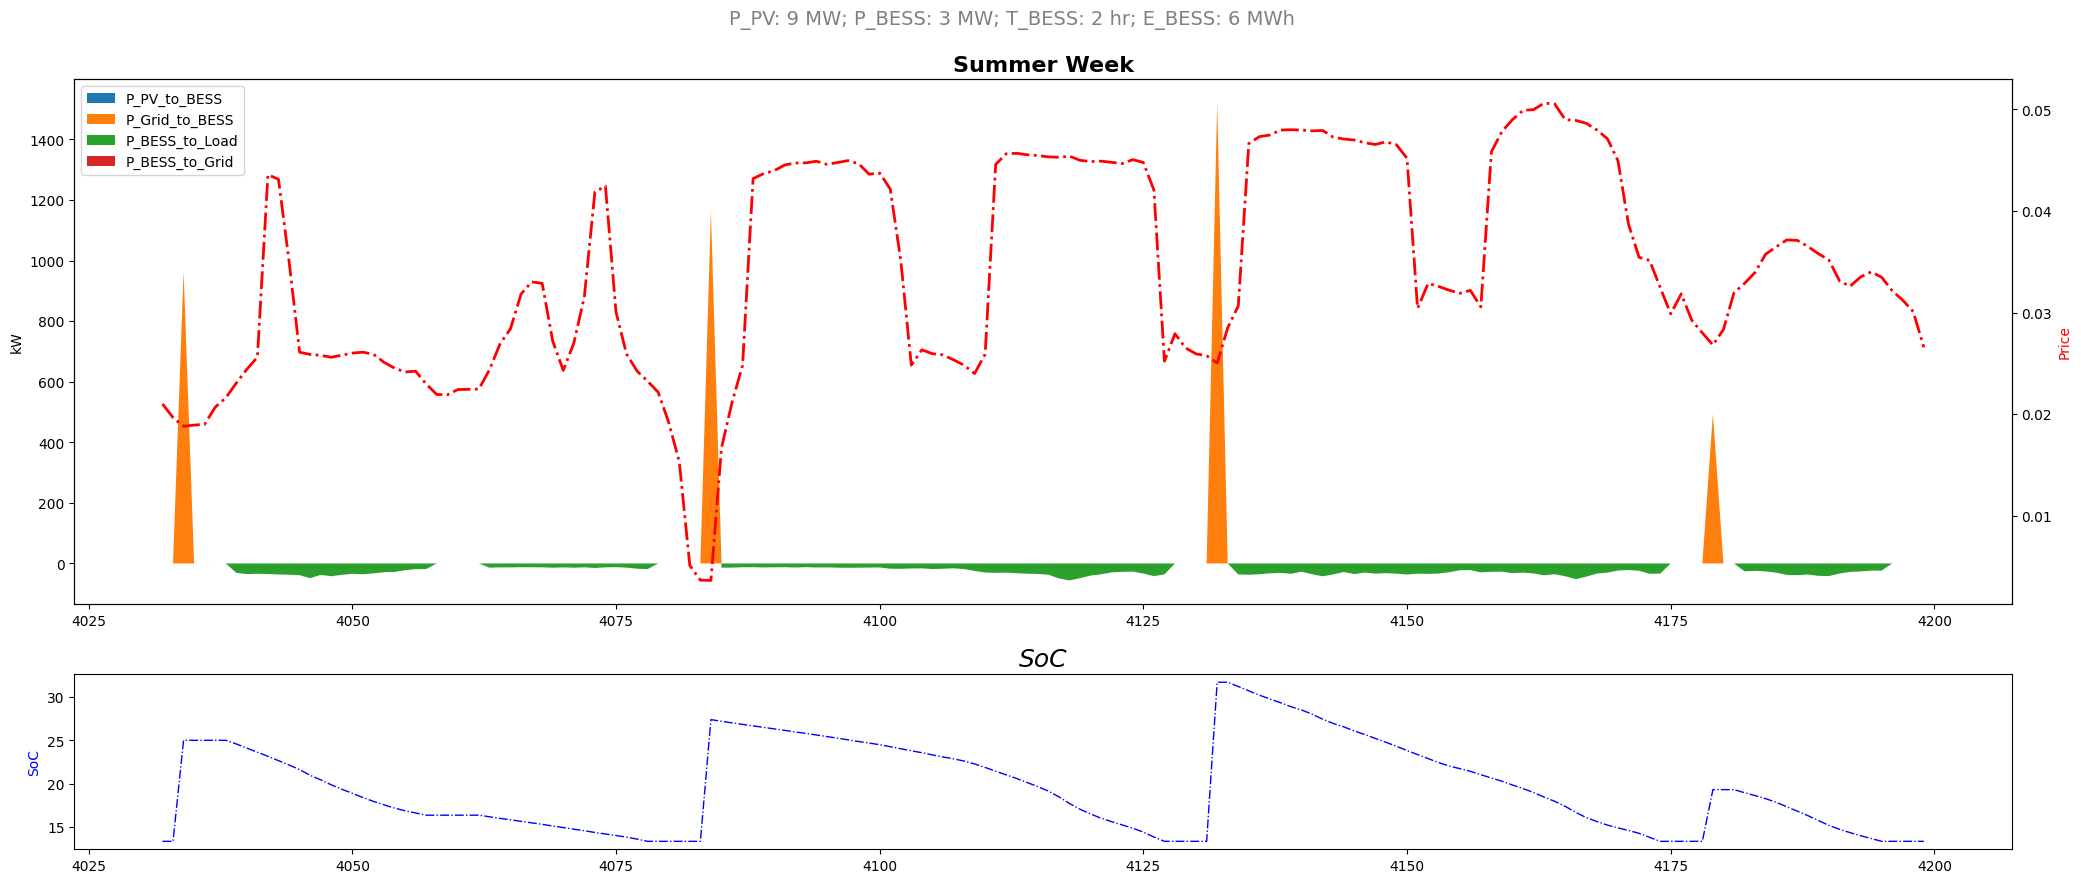

In [36]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a 2x1 grid of subplots with different heights
fig = plt.figure(figsize=(25, 10))
gs = GridSpec(2, 1, height_ratios=[3, 1])

# Stackplot on the primary y-axis (top subplot)
ax5 = fig.add_subplot(gs[0])
ax5.stackplot(
    profile[(week * 168):(week + 1) * 168].Hour,
    profile[(week * 168):(week + 1) * 168].P_PV_to_BESS,
    profile[(week * 168):(week + 1) * 168].P_Grid_to_BESS,
    profile[(week * 168):(week + 1) * 168].P_BESS_to_Load,
    profile[(week * 168):(week + 1) * 168].P_BESS_to_Grid,
    labels=['P_PV_to_BESS', 'P_Grid_to_BESS', 'P_BESS_to_Load', 'P_BESS_to_Grid']
)
ax5.set_ylabel('kW', color='black')

# Line plot on the secondary y-axis (top subplot)
ax6 = ax5.twinx()
ax6.plot(
    profile[(week * 168):(week + 1) * 168].Hour,
    data[(week * 168):(week + 1) * 168].Price,
    linestyle='dashdot',
    linewidth=2,
    color='red'  # Specify the color for the line plot
)

# Set y-axis label for the secondary y-axis (top subplot)
ax6.set_ylabel('Price', color='red')

# Create a twin Axes sharing the x-axis (bottom subplot)
ax7 = fig.add_subplot(gs[1], sharex=ax5)
ax7.plot(
    profile[(week * 168):(week + 1) * 168].Hour,
    profile[(week * 168):(week + 1) * 168].SoC,
    linestyle='dashdot',
    linewidth=1,
    color='blue'  # Specify the color for the line plot
)

# Set y-axis label for the secondary y-axis (bottom subplot)
ax7.set_ylabel('SoC', color='blue')

# Combine legends for the top subplot
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax6.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Set title
#plt.title('P_PV: 10 MW; P_BESS: 5 MW; T_BESS: 4 hr')
ax5.set_title('Summer Week', fontsize=16, fontweight='bold')
fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')
ax7.set_title('SoC', fontsize= 18, fontstyle='italic')

# Show the plot
plt.show()


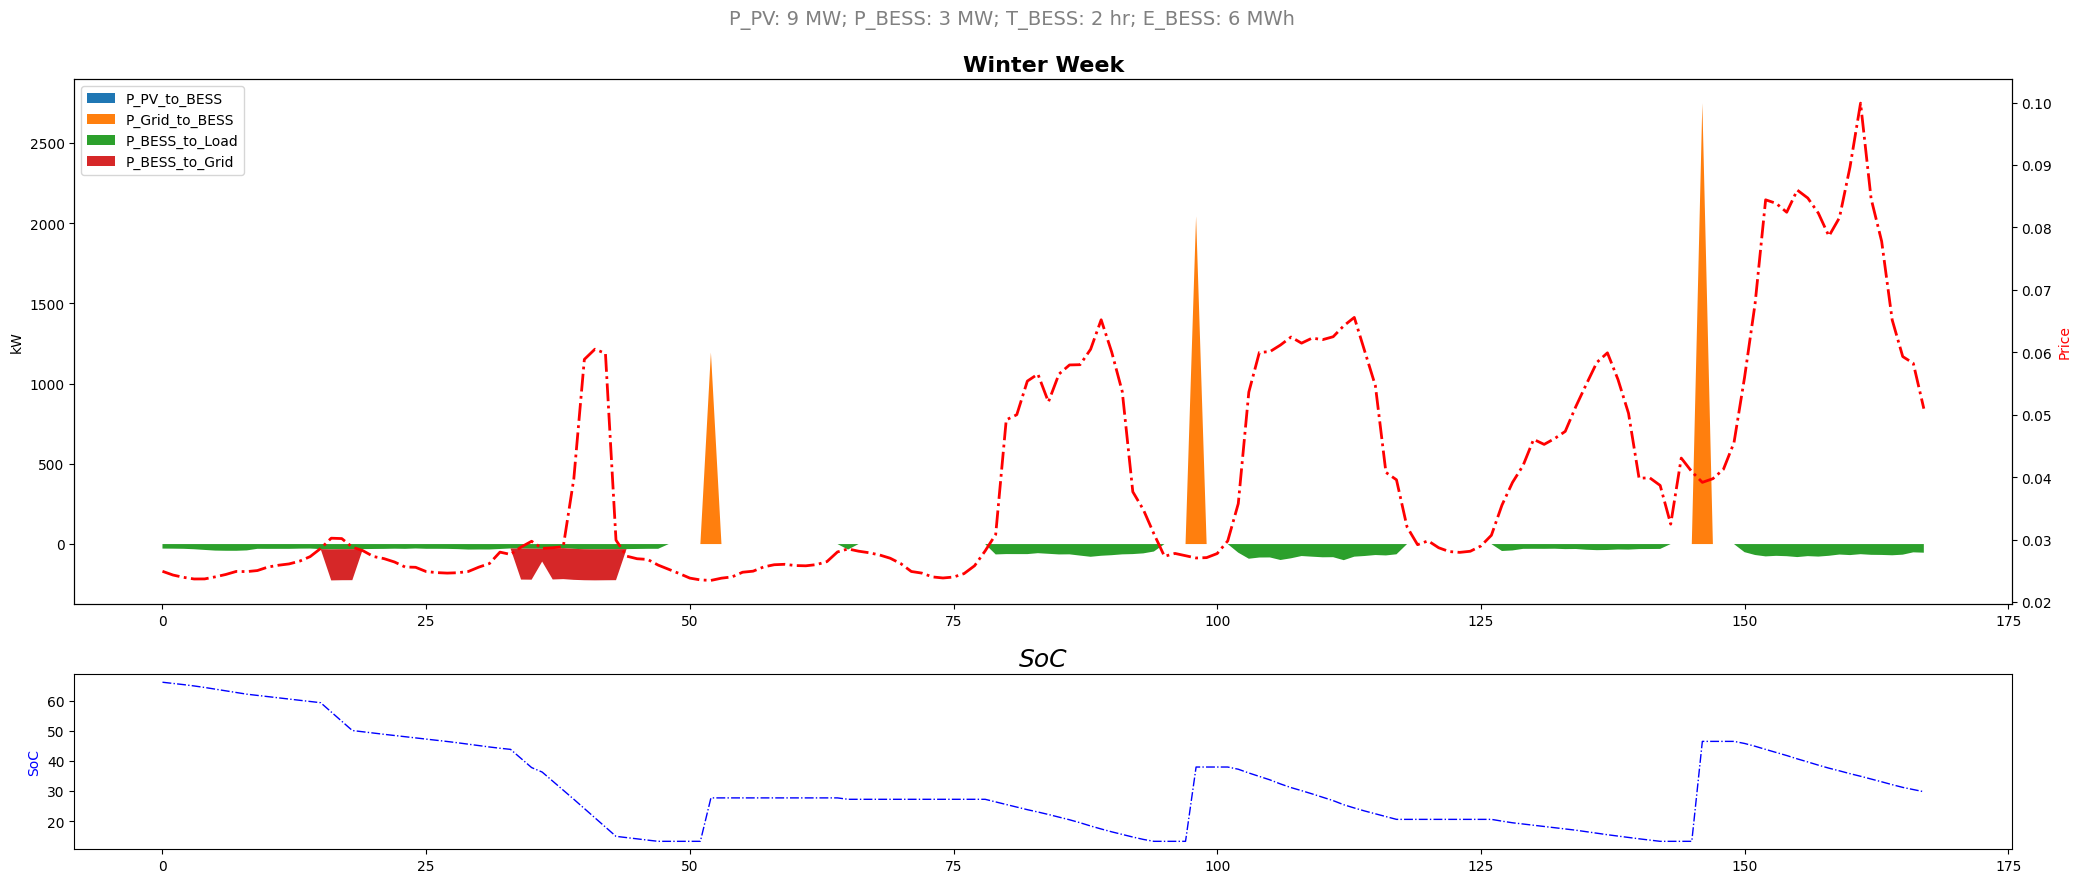

In [37]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a 2x1 grid of subplots with different heights
fig = plt.figure(figsize=(25, 10))
gs = GridSpec(2, 1, height_ratios=[3, 1])

# Stackplot on the primary y-axis (top subplot)
ax1 = fig.add_subplot(gs[0])
ax1.stackplot(
    profile[:168].Hour,
    profile[:168].P_PV_to_BESS,
    profile[:168].P_Grid_to_BESS,
    profile[:168].P_BESS_to_Load,
    profile[:168].P_BESS_to_Grid,
    labels=['P_PV_to_BESS', 'P_Grid_to_BESS', 'P_BESS_to_Load', 'P_BESS_to_Grid']
)
ax1.set_ylabel('kW', color='black')

# Line plot on the secondary y-axis (top subplot)
ax2 = ax1.twinx()
ax2.plot(
    profile[:168].Hour,
    data[:168].Price,
    linestyle='dashdot',
    linewidth=2,
    color='red'  # Specify the color for the line plot
)

# Set y-axis label for the secondary y-axis (top subplot)
ax2.set_ylabel('Price', color='red')

# Create a twin Axes sharing the x-axis (bottom subplot)
ax3 = fig.add_subplot(gs[1], sharex=ax1)
ax3.plot(
    profile[:168].Hour,
    profile[:168].SoC,
    linestyle='dashdot',
    linewidth=1,
    color='blue'  # Specify the color for the line plot
)

# Set y-axis label for the secondary y-axis (bottom subplot)
ax3.set_ylabel('SoC', color='blue')

# Combine legends for the top subplot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Set title
#plt.title('P_PV: 10 MW; P_BESS: 5 MW; T_BESS: 4 hr')
ax1.set_title('Winter Week', fontsize=16, fontweight='bold')
fig.suptitle(f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh', x=0.5, y=0.95, fontsize=14, color='gray')
ax3.set_title('SoC', fontsize= 18, fontstyle= 'italic')

# Show the plot
plt.show()


In [41]:
profile['ArbitrageFlow']=   profile['P_PV_to_Grid'] + profile['P_BESS_to_Grid']
profile.describe()

,Hour,P_PV_to_Load,P_PV_to_BESS,P_PV_curtailment,P_PV_to_Grid,P_BESS_to_Load,P_BESS_to_Grid,P_Grid_to_Load,P_Grid_to_BESS,SoC,sum_power_flows,ArbitrageFlow
count,6200.000000,6200.000000,6200.000000,6200.0,6200.000000,6200.000000,6200.000000,6.200000e+03,6200.000000,6200.000000,6200.000000,6200.000000
mean,3099.500000,0.048767,0.001142,0.0,0.000005,-24.431798,-2.164410,1.149484e+01,30.283299,20.511213,39.531138,-2.164405
std,1789.930166,0.079644,0.010287,0.0,0.000376,22.334234,20.306826,1.756873e+01,225.202540,9.776884,17.869588,20.306827
min,0.000000,0.000000,0.000000,0.0,0.000000,-100.484894,-193.330000,-7.105427e-15,0.000000,13.333333,12.534697,-193.330000
25%,1549.750000,0.000000,0.000000,0.0,0.000000,-41.117532,0.000000,0.000000e+00,0.000000,14.122121,24.856643,0.000000
50%,3099.500000,0.000109,0.000000,0.0,0.000000,-22.924350,0.000000,0.000000e+00,0.000000,17.394344,37.165823,0.000000
75%,4649.250000,0.074447,0.000000,0.0,0.000000,0.000000,0.000000,2.294675e+01,0.000000,23.487574,50.927198,0.000000
max,6199.000000,0.313435,0.223584,0.0,0.029604,-0.000000,0.000000,7.710901e+01,5238.000000,120.000000,115.102971,0.029604


In [ ]:
base = alt.Chart(
    profile[:168],
    title= alt.Title(
        'BESS flows & SoC',
        subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    )

).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (0, 170))
).properties(
    height= 300,
    width= 1200,
)
base2 = alt.Chart(data[:168]).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (0, 170))
).properties(
    height= 300,
    width= 1200,
)

profile_curves = base.mark_area().transform_fold(
    fold = [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
    as_ = ['System Profiles', 'Legend']
).encode(
    alt.Y('Legend:Q', axis = alt.Axis(title = '[MW]')).scale(domain= (-1050, 1050)),
    alt.Color(
        'System Profiles:N',
        legend= alt.Legend(
            values= [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
            #orient= 'right'
        )
    ).scale(
        scheme= 'dark2',
        #domain= (0, 50)
    ),
)
system = base2.mark_line(color = 'blue').encode(
    alt.Y(
        'Load',
        axis = alt.Axis(
            title = '[MW]',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 8)),
)
soc = base.mark_line(size=0.5, color = 'blue', interpolate= 'basis', strokeDash=(5, 3)).encode(
    alt.Y(
        'SoC',
        axis = alt.Axis(
            title = 'SoC [%]',
            #titleColor = 'blue'
        )
    ).scale(domain= (0, 100)),
).properties(
    height= 100,
    width= 1200
)

upper= profile_curves
lower= soc

upper & lower


alt.VConcatChart(...)

In [44]:
base = alt.Chart(
    profile[:168],
    title= alt.Title(
        'BESS flows & SoC',
        subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    )

).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (0, 170))
).properties(
    height= 300,
    width= 1200,
)
base2 = alt.Chart(data[:168]).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (0, 170))
).properties(
    height= 300,
    width= 1200,
)

profile_curves = base.mark_bar().transform_fold(
    fold = [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
    as_ = ['System Profiles', 'Legend']
).encode(
    alt.Y('Legend:Q', axis = alt.Axis(title = '[MW]')).scale(domain= (-1050, 1050)),
    alt.Color(
        'System Profiles:N',
        legend= alt.Legend(
            values= [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
            #orient= 'right'
        )
    ).scale(
        scheme= 'dark2',
        #domain= (0, 50)
    ),
)
system = base2.mark_line(color = 'blue').encode(
    alt.Y(
        'Load',
        axis = alt.Axis(
            title = '[MW]',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 8)),
)
price = base2.mark_line(color = 'red').encode(
    alt.Y(
        'Price',
        axis = alt.Axis(
            title = '',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 80)),
)
soc = base.mark_line(size=0.5, color = 'blue', interpolate= 'basis', strokeDash=(5, 3)).encode(
    alt.Y(
        'SoC',
        axis = alt.Axis(
            title = 'SoC [%]',
            #titleColor = 'blue'
        )
    ).scale(domain= (0, 100)),
).properties(
    height= 100,
    width= 1200
)

#upper= alt.layer(profile_curves, price).resolve_axis('independent')
upper= alt.layer(
    profile_curves,
    price.encode(
        alt.Y('Price', axis=alt.Axis(title='Price [$]', titleColor='red'))
    )).resolve_scale(y= 'independent')
lower= soc

upper & lower

# alt.layer(
#     profile_curves,
#     #system,
#     soc
# ).resolve_scale(
#     y = 'independent',
# ).resolve_legend(
#     color= 'independent',
# ).configure_axis(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_legend(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_title(
#     fontSize= 20
# )

#profile_curves

alt.VConcatChart(...)

In [ ]:
base = alt.Chart(
    profile[(week - 1)*168:week*168],
    title= alt.Title(
        'BESS flows & SoC',
        subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    )

).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4030, 4200))
).properties(
    height= 300,
    width= 1200,
)
base2 = alt.Chart(data[24*168:25*168]).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4030, 4200))
).properties(
    height= 300,
    width= 1200,
)

profile_curves = base.mark_area().transform_fold(
    fold = [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
    as_ = ['System Profiles', 'Legend']
).encode(
    alt.Y('Legend:Q', axis = alt.Axis(title = '[MW]')).scale(domain= (-1050, 1050)),
    alt.Color(
        'System Profiles:N',
        legend= alt.Legend(
            values= [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
            #orient= 'right'
        )
    ).scale(
        scheme= 'dark2',
        #domain= (0, 50)
    ),
)
system = base2.mark_line(color = 'blue').encode(
    alt.Y(
        'Load',
        axis = alt.Axis(
            title = '[MW]',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 8)),
)
soc = base.mark_line(size=0.5, color = 'blue', interpolate= 'basis', strokeDash=(5, 3)).encode(
    alt.Y(
        'SoC',
        axis = alt.Axis(
            title = 'SoC [%]',
            #titleColor = 'blue'
        )
    ).scale(domain= (0, 100)),
).properties(
    height= 100,
    width= 1200
)

upper= profile_curves
lower= soc

upper & lower


alt.VConcatChart(...)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8833 entries, 0 to 8832
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Hour      8833 non-null   int64  
 1   Load      8833 non-null   float64
 2   Price     8833 non-null   float64
 3   CO_2_eq   8833 non-null   float64
 4   solar_PV  8833 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 345.2 KB


In [ ]:
base = alt.Chart(
    profile[(week)*168:(week + 1)*168],
    # title= alt.Title(
    #     'BESS flows & SoC',
    #     subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    # )
).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4030, 4200))
).properties(
    height= 300,
    width= 1200,
)
base2 = alt.Chart(data[week*168:(week + 1)*168]).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4030, 4200))
).properties(
    height= 300,
    width= 1200,
)

profile_curves = base.mark_bar().transform_fold(
    fold = [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
    as_ = ['System Profiles', 'Legend']
).encode(
    alt.Y('Legend:Q', axis = alt.Axis(title = '[MW]')).scale(domain= (-3600, 3600)),
    alt.Color(
        'System Profiles:N',
        legend= alt.Legend(
            values= [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
            #orient= 'right'
        )
    ).scale(
        scheme= 'dark2',
        #domain= (0, 50)
    ),
)
system = base2.mark_line(color = 'blue').encode(
    alt.Y(
        'Load',
        axis = alt.Axis(
            title = '[MW]',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 8)),
)
price = base2.mark_line(color = 'red').encode(
    alt.Y(
        'Price',
        axis = alt.Axis(
            title = '',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 80)),
)
co2 = base2.mark_line(color = 'green').encode(
    alt.Y(
        'CO_2_eq',
        axis = alt.Axis(
            title = '',
            #titleColor = 'blue'
        )
    )#.scale(domain= (-0.1, 80)),
)
soc = base.mark_line(size=0.5, color = 'blue', interpolate= 'basis', strokeDash=(5, 3)).encode(
    alt.Y(
        'SoC',
        axis = alt.Axis(
            title = 'SoC [%]',
            #titleColor = 'blue'
        )
    ).scale(domain= (0, 100)),
).properties(
    height= 100,
    width= 1200
)

#upper= alt.layer(profile_curves, price).resolve_axis('independent')
upper= alt.layer(
    profile_curves,
    price.mark_line(color= 'red', strokeDash= (5, 5)).encode(
        alt.Y('Price', axis=alt.Axis(title='Price [EUR/kWh]', titleColor='red'))
    ),
    # co2.mark_line(color= 'green', strokeDash= (5, 5)).encode(
    #     alt.Y('CO_2_eq', axis=alt.Axis(title='CO2eq Intensity of Electricity Production [gCO2eq/kWh]', titleColor='green')).scale(domain= (0.03, 0.04))
    # )
).resolve_scale(y= 'independent')
lower= soc
upper & lower



alt.VConcatChart(...)

In [48]:
base = alt.Chart(
    profile[(week)*168:(week + 1)*168],
    title= alt.Title(
        'BESS flows & SoC',
        subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    )
).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4030, 4200))
).properties(
    height= 300,
    width= 1200,
)
base2 = alt.Chart(data[24*168:25*168]).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4030, 4200))
).properties(
    height= 300,
    width= 1200,
)

profile_curves = base.mark_area().transform_fold(
    fold = [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        'P_PV_to_Grid'
        ],
    as_ = ['System Profiles', 'Legend']
).encode(
    alt.Y('Legend:Q', axis = alt.Axis(title = '[MW]')).scale(domain= (-1050, 4050)),
    alt.Color(
        'System Profiles:N',
        legend= alt.Legend(
            values= [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        'P_PV_to_Grid'
        ],
            #orient= 'right'
        )
    ).scale(
        scheme= 'dark2',
        #domain= (0, 50)
    ),
)
system = base2.mark_line(color = 'blue').encode(
    alt.Y(
        'Load',
        axis = alt.Axis(
            title = '[MW]',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 8)),
)
soc = base.mark_line(size=0.5, color = 'blue', interpolate= 'basis', strokeDash=(5, 3)).encode(
    alt.Y(
        'SoC',
        axis = alt.Axis(
            title = 'SoC [%]',
            #titleColor = 'blue'
        )
    ).scale(domain= (0, 100)),
).properties(
    height= 100,
    width= 1200
)

upper= profile_curves
lower= soc

upper & lower

# alt.layer(
#     profile_curves,
#     #system,
#     soc
# ).resolve_scale(
#     y = 'independent',
# ).resolve_legend(
#     color= 'independent',
# ).configure_axis(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_legend(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_title(
#     fontSize= 20
# )

#profile_curves

alt.VConcatChart(...)

In [49]:
base = alt.Chart(
    profile[week*168:(week + 1)*168],
    title= alt.Title(
        'BESS flows & SoC',
        subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    )
).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4200, 4370))
).properties(
    height= 300,
    width= 1200,
)
base2 = alt.Chart(data[week*168:(week + 1)*168]).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4200, 4370))
).properties(
    height= 300,
    width= 1200,
)

profile_curves = base.mark_area().transform_fold(
    fold = [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
    as_ = ['System Profiles', 'Legend']
).encode(
    alt.Y('Legend:Q', axis = alt.Axis(title = '[MW]')).scale(domain= (-1050, 1050)),
    alt.Color(
        'System Profiles:N',
        legend= alt.Legend(
            values= [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        ],
            #orient= 'right'
        )
    ).scale(
        scheme= 'dark2',
        #domain= (0, 50)
    ),
)
system = base2.mark_line(color = 'blue').encode(
    alt.Y(
        'Load',
        axis = alt.Axis(
            title = '[MW]',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 8)),
)
soc = base.mark_line(size=0.5, color = 'blue', interpolate= 'basis', strokeDash=(5, 3)).encode(
    alt.Y(
        'SoC',
        axis = alt.Axis(
            title = 'SoC [%]',
            #titleColor = 'blue'
        )
    ).scale(domain= (0, 100)),
).properties(
    height= 100,
    width= 1200
)

upper= profile_curves
lower= soc

upper & lower

# alt.layer(
#     profile_curves,
#     #system,
#     soc
# ).resolve_scale(
#     y = 'independent',
# ).resolve_legend(
#     color= 'independent',
# ).configure_axis(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_legend(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_title(
#     fontSize= 20
# )

#profile_curves

alt.VConcatChart(...)

In [50]:
base = alt.Chart(
    profile[week*168:(week + 1)*168],
    title= alt.Title(
        'BESS flows & SoC',
        subtitle= f'P_PV: {p_solar} MW; P_BESS: {p_bess} MW; T_BESS: {t_bess} hr; E_BESS: {e_bess} MWh'
    )
).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4200, 4370))
).properties(
    height= 300,
    width= 1200,
)
base2 = alt.Chart(data[week*168:(week + 1)*168]).encode(
    alt.X('Hour:Q', axis = alt.Axis(title = 'Hour in year', format= 'd')).scale(domain= (4200, 4370))
).properties(
    height= 300,
    width= 1200,
)

profile_curves = base.mark_area().transform_fold(
    fold = [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        'P_PV_to_Grid'
        ],
    as_ = ['System Profiles', 'Legend']
).encode(
    alt.Y('Legend:Q', axis = alt.Axis(title = '[MW]')).scale(domain= (-1050, 4050)),
    alt.Color(
        'System Profiles:N',
        legend= alt.Legend(
            values= [
        'P_BESS_to_Load',
        'P_PV_to_BESS',
        'P_BESS_to_Grid',
        'P_Grid_to_BESS',
        'P_PV_to_Grid'
        ],
            #orient= 'right'
        )
    ).scale(
        scheme= 'dark2',
        #domain= (0, 50)
    ),
)
system = base2.mark_line(color = 'blue').encode(
    alt.Y(
        'Load',
        axis = alt.Axis(
            title = '[MW]',
            #titleColor = 'blue'
        )
    ).scale(domain= (-0.1, 8)),
)
soc = base.mark_line(size=0.5, color = 'blue', interpolate= 'basis', strokeDash=(5, 3)).encode(
    alt.Y(
        'SoC',
        axis = alt.Axis(
            title = 'SoC [%]',
            #titleColor = 'blue'
        )
    ).scale(domain= (0, 100)),
).properties(
    height= 100,
    width= 1200
)

upper= profile_curves
lower= soc

upper & lower

# alt.layer(
#     profile_curves,
#     #system,
#     soc
# ).resolve_scale(
#     y = 'independent',
# ).resolve_legend(
#     color= 'independent',
# ).configure_axis(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_legend(
#     labelFontSize= 20,
#     titleFontSize= 20,
# ).configure_title(
#     fontSize= 20
# )

#profile_curves

alt.VConcatChart(...)